# <p style="text-align: center;">  Summary Statistics </p>


#### What do we wish to accomplish?

1. The first step is to create a linear regression model, determine which parameters are significant, and then continuously repeat this process until we have a good model.

2. How can we determine how great the model is? We can look at the adjusted R-Squared of our model. We will also take a look at residual plots to find outliers and leverage points.



Initial thoughts:

We are attempting to determine whether or not a play results in a first down conversion, or whether or not to 'go for it' on a fourth down. 

In [1]:
# Everybody's favorite imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("plays_4thdowns.csv")

# Getting the columns necessary
newdata = data[["down", "quarter", 'yardsToGo', 'yardlineNumber', 'defendersInTheBox', 
                'numberOfPassRushers', 'HomeScoreBeforePlay', 'HomeScoreAfterPlay', 'VisitorScoreBeforePlay',
               'VisitorScoreBeforePlay', 'isPenalty', 'PassLength', 'YardsAfterCatch', 'PlayResult',
               'firstDown_Conversion']]
newdata['isPenalty'] = newdata['isPenalty'].map({'False': 0, 'True': 1})
newdata = newdata.dropna()


In [15]:
# Creating train and test sets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


# Split the dataset into training and testing sets (70-30 split is ideal)
X_train, X_test, y_train, y_test = train_test_split(newdata.drop('firstDown_Conversion', axis=1), 
                                                    newdata['firstDown_Conversion'], test_size=0.3, random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
# Print the size of the training and testing sets
print(f"Training set size: {len(X_train_scaled)}\nTest set size: {len(X_test_scaled)}")

Training set size: 28
Test set size: 13


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

# Create a logistic regression model and fit it to the training data
lr_model = LogisticRegression()
lr_model.fit(X_train_scaled, y_train)

# Use the trained model to make predictions on the testing data
y_pred = lr_model.predict(X_test_scaled)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8461538461538461


We received an accuracy score of 0.84. That's not bad! However, we want to aim to get this model to have an accuracy of at least 0.95 (this is preference, but I believe this is a good score).

In [18]:
print("Coefficients: ", lr_model.coef_, '\n')
print("Intercept: ", lr_model.intercept_, '\n')

Coefficients:  [[ 0.          0.20926573 -1.30719237 -0.11438444  0.08860396  0.01600228
  -0.33294878 -0.27275749  0.14064413  0.14064413  0.11932494  0.77623665
  -0.01401811  0.74653284]] 

Intercept:  [2.39032988] 



Lets take a look at some residual plots!

C:\Users\jeffr\Anaconda3\Anaconda\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in true_divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


<AxesSubplot:ylabel='firstDown_Conversion'>

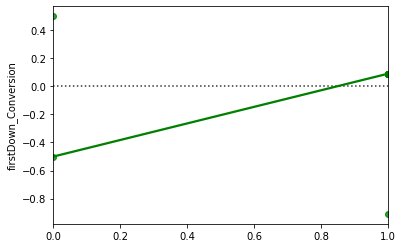

In [24]:
import seaborn as sns



residuals = y_test - y_pred
residuals
sns.residplot(y_pred, residuals, lowess=True, color="g")

# I guess this was kinda useful for logistic regression

In [25]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test, y_pred)
confusion

array([[ 1,  1],
       [ 1, 10]], dtype=int64)

Interesting, we received 1 True Positive and 10 True Negatives, and only 1 False Pos. and 1 False Neg.

#### Decision Tree

In [36]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

dt = DecisionTreeRegressor(random_state=42)

# Train the decision tree classifier on the training set
dt.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = dt.predict(X_test_scaled)

# Evaluate the accuracy of the decision tree classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 69.23%


In [42]:
print(tree.export_text(dt, feature_names = list(pd.DataFrame(X_train_scaled).columns)) )

|--- 2 <= 0.52
|   |--- 5 <= -1.24
|   |   |--- value: [0.00]
|   |--- 5 >  -1.24
|   |   |--- 8 <= -1.24
|   |   |   |--- 1 <= -0.16
|   |   |   |   |--- value: [1.00]
|   |   |   |--- 1 >  -0.16
|   |   |   |   |--- value: [0.00]
|   |   |--- 8 >  -1.24
|   |   |   |--- value: [1.00]
|--- 2 >  0.52
|   |--- 12 <= 0.90
|   |   |--- value: [0.00]
|   |--- 12 >  0.90
|   |   |--- value: [1.00]



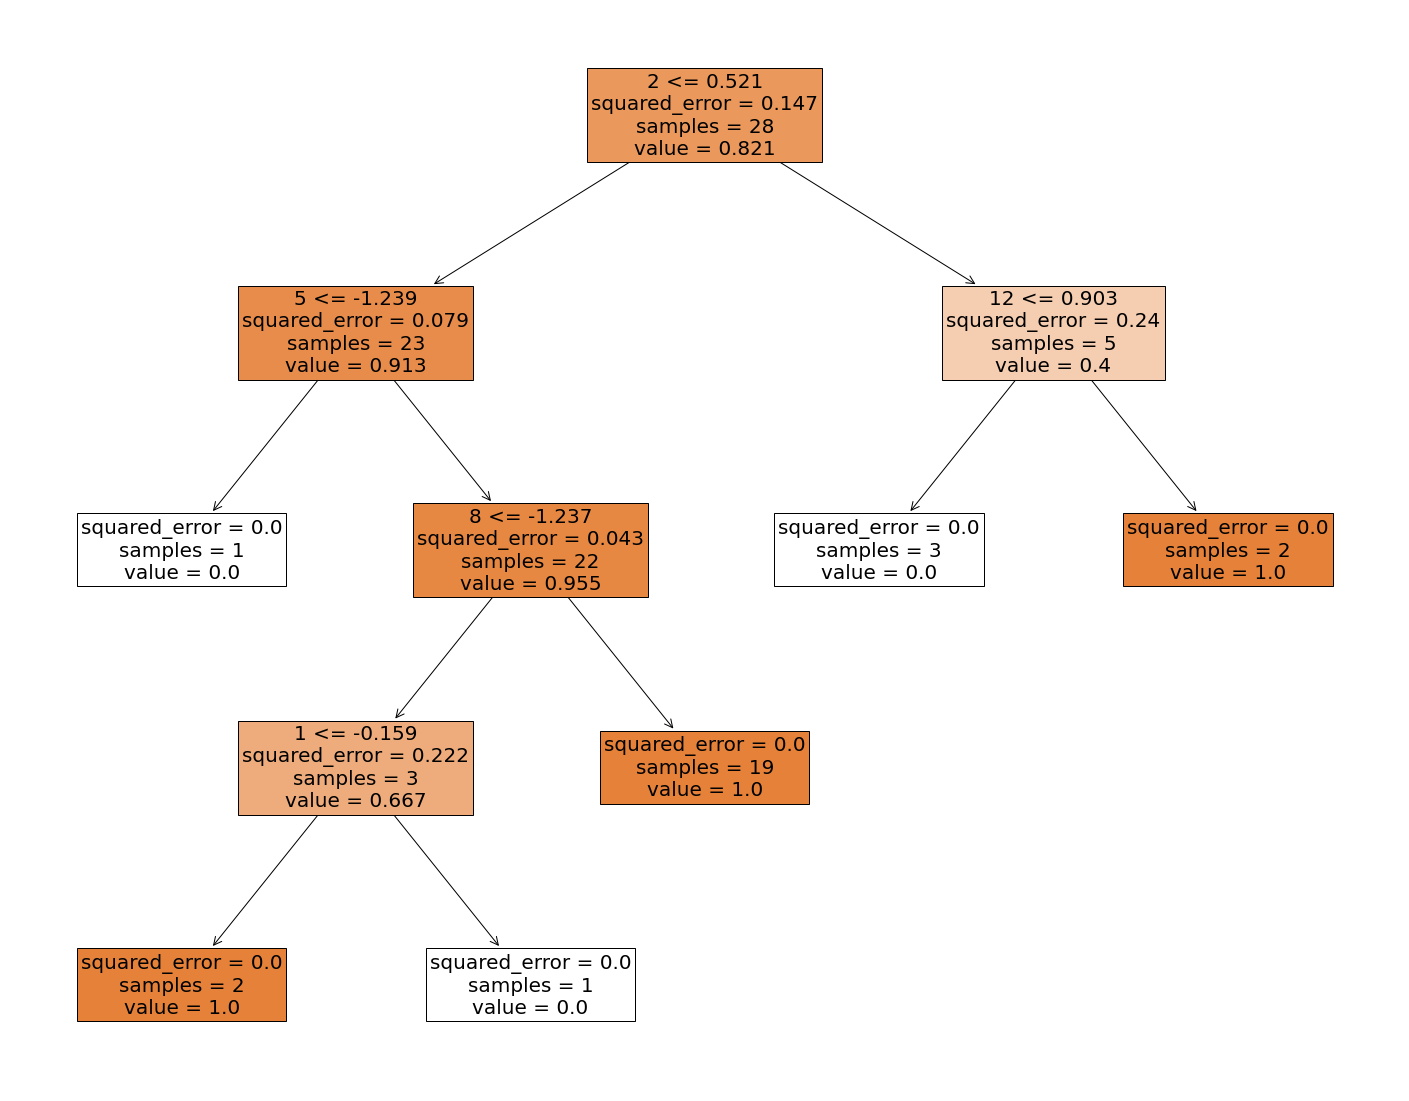

In [43]:
fig = plt.figure(figsize = (25,20))
_= tree.plot_tree(dt, feature_names = list(pd.DataFrame(X_train_scaled).columns), 
               filled = True, 
              fontsize = 20)

In [77]:
from sklearn.metrics import mean_squared_error

yhat = dt.predict(pd.DataFrame(X_test_scaled))
mean_squared_error(y_test, yhat)

0.3076923076923077

#### Support Vector Machine 

In [57]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC 
    
C_list = [0.001, 0.01, 0.1, 1, 5, 10, 100]
tuned_parameters = [{'C': C_list}]
clf = GridSearchCV(SVC(kernel='linear'), tuned_parameters, cv=5, scoring='accuracy')
clf.fit(X_train_scaled, y_train)

# Our best parameter is C=5
clf.best_params_

{'C': 5}

In [58]:
clf = SVC(kernel='linear', C=5)
clf.fit(pd.DataFrame(X_train_scaled), y_train)

SVC(C=5, kernel='linear')

In [78]:
pred = clf.predict(X_test_scaled)
mean_squared_error(y_test, pred)

0.23076923076923078

#### Linear Regression Model

In [81]:
X_train, X_test, y_train, y_test = train_test_split(newdata.drop('firstDown_Conversion', axis=1), 
                                                    newdata['firstDown_Conversion'], test_size=0.3, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_new = model.predict(X_test)
mean_squared_error(y_test, y_new)

0.13105035932888767